<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [40]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [41]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [42]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [43]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [44]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [45]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [46]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [47]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  3.,  8.],
       [ 9., 10.,  0.,  2.,  6.,  5.,  0.,  8.],
       [ 4.,  7.,  0.,  6.,  0., 10., 10.,  2.],
       [ 0.,  7.,  9.,  0.,  5., 10.,  9.,  0.],
       [ 7.,  6.,  3.,  0.,  3.,  0.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  0.,  8.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  3.,  3.,  9.,  0.],
       [ 0., 10., 10.,  0.,  2.,  2.,  2.,  2.],
       [ 9.,  0.,  0.,  8.,  0.,  3.,  1.,  0.],
       [ 9.,  0., 10.,  9.,  0.,  4.,  2.,  1.],
       [ 4.,  0.,  3.,  3.,  9.,  9.,  0., 10.],
       [ 2.,  2.,  4.,  1.,  0.,  0., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  0.,  0.,  7.,  8.],
       [ 3.,  3.,  0.,  0.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8.,  0.,  4.,  2.,  0.,  0.]])

In [48]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  9.,  0.],
       [ 3.,  5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  0.,  0.,  8., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7., 10.,  0.,  0.],
       [ 0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  1.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [49]:
train, val = train_test_split(train, qtd = 2)

In [50]:
train

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  6.,  5.,  0.,  8.],
       [ 4.,  0.,  0.,  6.,  0.,  0., 10.,  2.],
       [ 0.,  7.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 7.,  6.,  3.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  9.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  2.,  2.,  2.],
       [ 9.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 9.,  0., 10.,  0.,  0.,  0.,  2.,  1.],
       [ 0.,  0.,  3.,  3.,  0.,  9.,  0., 10.],
       [ 2.,  0.,  4.,  1.,  0.,  0.,  0.,  9.],
       [ 1.,  0.,  1.,  3.,  0.,  0.,  0.,  8.],
       [ 3.,  3.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 9.,  9.,  8.,  0.,  0.,  0.,  0.,  0.]])

In [51]:
val

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  8.],
       [ 9., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  0.,  3.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  8.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  4.,  0.,  0.],
       [ 4.,  0.,  0.,  0.,  9.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.,  7.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0.,  4.,  2.,  0.,  0.]])

In [52]:
test

array([[ 0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  9.,  0.],
       [ 3.,  5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  0.,  0.,  8., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7., 10.,  0.,  0.],
       [ 0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  1.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [53]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [54]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [55]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [56]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [57]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,6.83,5.31,6.69,6.30,6.88,6.16,8.38,5.26
User_2,4.56,4.22,4.45,2.03,5.79,5.24,2.54,7.65
User_3,4.02,3.33,2.93,5.89,4.08,4.81,9.74,2.05
User_4,8.23,7.02,8.81,7.03,9.18,9.71,9.57,9.72
User_5,6.41,6.07,3.28,2.46,4.64,2.63,4.74,1.99
User_6,8.63,5.75,10.33,8.73,9.05,7.66,9.61,7.00
User_7,3.22,2.52,1.76,5.16,2.97,3.16,8.72,0.27
User_8,7.73,4.66,9.59,4.64,5.71,2.05,1.98,2.02
User_9,8.74,6.02,8.54,5.37,7.03,3.01,4.72,2.93
User_10,8.70,5.40,9.78,4.71,5.98,1.30,2.06,1.07


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [58]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0
User_2,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
User_3,0.0,7.0,0.0,0.0,0.0,10.0,0.0,0.0
User_4,0.0,0.0,0.0,0.0,5.0,0.0,9.0,0.0
User_5,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0
User_6,0.0,0.0,9.0,0.0,0.0,8.0,0.0,0.0
User_7,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0
User_8,0.0,10.0,0.0,0.0,2.0,0.0,0.0,0.0
User_9,0.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0
User_10,0.0,0.0,0.0,9.0,0.0,4.0,0.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [59]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df = getData()
print(df.shape)
df

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df.shape

(367, 80)

In [64]:
ratings = R.fillna(0).values
ratings

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [65]:
ratings.shape

(367, 80)

In [66]:
ratings

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [67]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [68]:
train, test = train_test_split(ratings, qtd = 2)

In [69]:
#matriz de interação - original;

ratings

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [70]:
train

array([[5., 3., 4., ..., 1., 4., 0.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [71]:
test

array([[0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
train + test

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [73]:
(train+test) == ratings

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [74]:
train, val = train_test_split(train, qtd = 2)

In [75]:
train

array([[5., 3., 4., ..., 1., 4., 0.],
       [4., 0., 0., ..., 0., 0., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [76]:
val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
test

array([[0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
train + val +test

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [79]:
(train+val+test) == ratings

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [80]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [81]:
fat.fit()

Fatoração concluída. Tempo aproximado: 12 minuto(s).


In [83]:
pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,3.85,2.87,3.09,3.58,2.97,3.96,4.25,3.65,4.31,4.18,...,3.55,3.08,2.98,2.40,3.79,3.33,2.90,1.68,3.80,2.93
User_1,3.78,2.51,3.67,3.24,2.94,3.13,4.30,2.79,4.03,3.70,...,3.44,3.12,2.93,2.02,3.94,3.43,2.74,1.51,3.68,2.70
User_2,3.24,2.47,1.82,3.38,2.30,3.17,3.21,3.73,3.60,3.33,...,3.08,2.53,2.75,2.28,2.44,2.76,2.51,1.80,3.30,2.43
User_3,4.40,3.52,3.64,3.81,3.75,2.91,4.31,4.26,4.41,4.13,...,4.05,3.92,3.70,3.34,3.96,4.05,3.79,2.51,4.61,2.95
User_4,4.21,3.65,3.01,3.70,3.65,3.14,4.03,4.31,4.11,3.89,...,3.95,3.58,3.61,3.33,3.66,3.61,3.75,2.48,4.38,2.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.31,2.80,2.43,3.05,2.83,2.31,3.05,3.85,3.47,3.37,...,3.05,3.05,2.82,2.88,2.73,3.13,2.97,2.12,3.60,2.26
User_363,4.16,3.69,2.95,3.80,3.60,3.78,4.06,4.78,4.45,4.50,...,3.84,3.60,3.40,3.47,3.76,3.65,3.68,2.39,4.38,3.01
User_364,3.69,3.04,2.49,3.57,2.87,4.58,4.05,3.99,4.26,4.32,...,3.43,2.80,2.81,2.48,3.59,2.96,2.84,1.61,3.62,2.97
User_365,3.49,3.04,2.78,3.01,3.11,2.77,3.43,3.66,3.59,3.57,...,3.20,3.10,2.86,2.85,3.29,3.13,3.11,1.98,3.67,2.43


In [84]:
pd.DataFrame((train+val+test), columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 7, steps = 2000, alpha = 0.00001, beta = 0.4)

In [86]:
fat.fit()

Fatoração concluída. Tempo aproximado: 6 minuto(s).


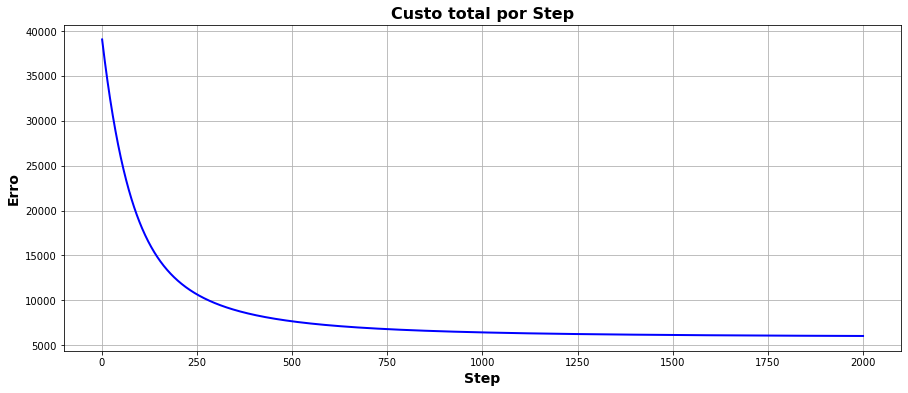

In [87]:
fat.print_MSE_steps()

In [88]:
pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,3.83,3.14,3.06,3.55,3.09,3.44,3.84,3.90,3.96,3.94,...,3.62,3.31,3.30,2.98,2.62,3.48,3.30,2.52,3.91,2.70
User_1,3.62,3.14,2.65,3.28,3.12,3.31,3.58,3.52,3.49,3.74,...,3.46,3.03,3.23,2.80,2.39,3.15,2.99,2.14,3.71,2.50
User_2,3.29,2.61,2.74,2.88,2.82,2.93,3.18,3.32,3.40,3.21,...,3.10,2.73,2.93,2.18,1.87,2.80,2.72,1.81,3.37,2.37
User_3,4.18,3.53,3.11,3.89,3.36,3.46,4.24,4.24,4.23,4.16,...,3.95,3.53,3.64,3.36,2.80,3.66,3.55,2.69,4.29,2.84
User_4,3.99,3.27,3.04,3.50,3.34,3.49,3.89,3.87,4.02,3.64,...,3.79,3.12,3.51,3.13,2.29,3.32,3.31,2.37,3.98,2.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.25,2.73,2.48,2.86,2.79,3.24,3.18,3.22,3.29,3.16,...,3.05,2.64,2.80,2.67,2.07,2.85,2.83,2.34,3.24,2.15
User_363,4.01,3.43,2.93,3.67,3.40,3.39,4.04,4.12,3.99,4.05,...,3.77,3.41,3.54,2.99,2.58,3.49,3.41,2.53,4.18,2.75
User_364,4.10,3.42,3.02,3.74,3.41,3.74,4.05,4.11,3.99,4.24,...,3.91,3.49,3.52,3.08,2.70,3.77,3.53,2.52,4.16,2.87
User_365,3.66,3.01,2.95,3.17,3.28,3.81,3.52,3.74,3.71,3.80,...,3.40,3.13,3.16,2.54,2.29,3.31,3.21,2.51,3.73,2.59


In [89]:
pd.DataFrame((train+val+test), columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


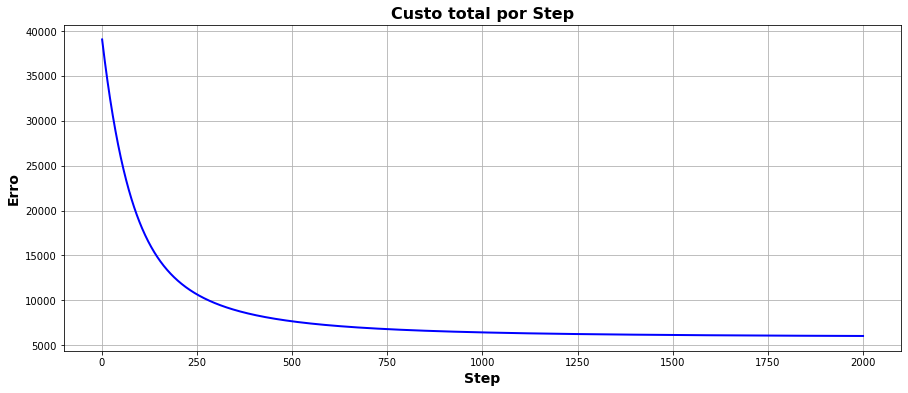

In [90]:
fat.print_MSE_steps()

In [91]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 7, steps = 1000, alpha = 0.000001, beta = 0.15)

In [92]:
fat.fit()

Fatoração concluída. Tempo aproximado: 3 minuto(s).


In [93]:
pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,3.39,2.60,2.34,3.25,2.49,2.35,3.00,3.27,3.55,3.12,...,2.89,1.59,2.34,2.30,1.55,2.29,2.76,1.88,3.53,1.70
User_1,3.62,2.80,2.42,3.59,2.40,2.14,3.29,3.72,3.80,3.53,...,3.29,1.95,2.54,2.49,1.70,2.10,3.22,2.26,3.41,1.73
User_2,2.89,2.30,1.65,3.15,2.35,1.54,2.83,3.25,3.20,3.07,...,2.54,1.73,2.14,1.99,1.67,1.47,2.51,1.84,2.80,1.56
User_3,3.12,2.56,2.23,3.21,2.77,2.06,3.08,3.71,3.67,3.50,...,2.84,1.93,2.58,2.35,1.94,1.86,2.91,2.19,3.21,1.44
User_4,2.77,2.31,1.09,2.31,2.20,1.69,2.33,2.87,2.92,2.82,...,2.13,1.58,1.74,1.78,1.58,1.12,2.17,1.51,2.44,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,1.56,1.10,1.33,1.86,1.11,0.92,1.55,1.64,1.66,1.59,...,1.54,0.88,1.30,1.16,0.76,1.10,1.43,0.99,1.63,0.89
User_363,3.27,2.70,1.61,2.45,2.06,2.21,2.47,2.84,3.21,2.71,...,2.46,1.34,1.62,1.97,1.26,1.78,2.42,1.59,2.99,1.43
User_364,2.79,2.03,2.48,3.44,2.48,1.83,2.73,2.97,3.08,2.99,...,2.55,1.59,2.31,2.19,1.57,2.06,2.32,1.55,3.09,1.79
User_365,2.79,2.11,1.57,2.38,2.26,2.04,2.19,2.59,2.78,2.80,...,2.15,1.54,1.89,1.94,1.53,1.51,2.01,1.20,2.62,1.51


In [94]:
pd.DataFrame((train+val+test), columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 7, steps = 750, alpha = 0.00001, beta = 0.1)

In [96]:
fat.fit()

Fatoração concluída. Tempo aproximado: 3 minuto(s).


In [97]:
pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,4.27,3.23,3.10,3.42,3.85,2.39,4.06,4.25,4.41,4.02,...,3.69,3.58,3.96,2.45,2.59,3.58,3.84,2.75,4.38,2.83
User_1,3.38,2.69,2.52,3.14,2.68,1.88,3.36,3.31,3.44,3.34,...,3.33,2.66,2.87,2.14,2.16,2.62,2.92,2.01,3.50,2.36
User_2,3.74,2.92,2.67,3.34,2.84,2.05,3.50,3.47,3.72,3.70,...,3.65,2.93,3.07,2.38,2.43,2.95,2.85,2.15,3.71,2.66
User_3,4.43,3.44,3.19,4.13,3.65,2.45,4.42,4.45,4.44,4.41,...,4.31,3.79,3.90,3.01,3.09,3.29,4.12,2.88,4.80,2.94
User_4,4.09,3.14,2.85,3.64,3.33,2.25,3.96,4.02,4.07,4.01,...,3.87,3.42,3.62,2.63,2.76,3.12,3.58,2.57,4.31,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.25,2.51,2.41,2.89,2.93,1.88,3.22,3.44,3.32,3.17,...,2.94,2.98,2.90,2.11,2.19,2.65,3.20,2.34,3.54,2.14
User_363,3.54,3.00,2.79,3.59,2.91,2.15,3.75,3.94,3.59,3.53,...,3.52,3.22,2.87,2.35,2.40,2.97,3.42,2.57,3.89,2.55
User_364,3.41,2.62,2.25,2.90,2.62,1.81,3.09,3.22,3.23,3.31,...,3.17,2.96,2.83,2.29,2.46,2.74,2.48,2.17,3.43,2.39
User_365,2.98,2.33,2.27,2.79,2.66,1.67,3.12,3.14,3.11,2.94,...,2.86,2.55,2.78,1.96,1.98,2.23,3.10,1.99,3.34,1.92


In [98]:
pd.DataFrame((train+val+test), columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


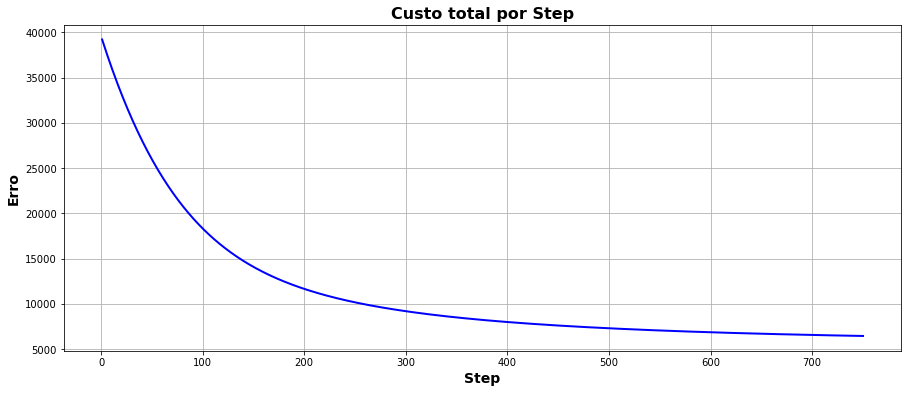

In [99]:
# Em todos os testes com steps, o máximo necessário foi de aproximadamente 750 steps

fat.print_MSE_steps()

In [100]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 750, alpha = 0.000001, beta = 0.2)

In [101]:
fat.fit()

Fatoração concluída. Tempo aproximado: 2 minuto(s).


In [102]:
pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,2.05,2.01,2.05,2.02,1.08,1.38,1.75,2.57,1.99,1.97,...,2.08,1.65,1.72,1.60,1.62,1.19,1.63,1.21,1.77,0.98
User_1,2.49,2.05,2.14,2.24,1.49,1.62,2.28,3.13,2.47,2.35,...,2.45,1.84,1.82,2.06,1.97,1.54,1.87,1.46,2.26,1.60
User_2,2.70,2.49,2.61,2.56,1.47,1.80,2.39,3.37,2.68,2.52,...,2.70,2.18,2.19,2.16,2.10,1.61,2.11,1.64,2.40,1.46
User_3,3.20,2.33,2.71,2.54,1.94,1.97,3.28,3.91,3.48,2.52,...,3.02,2.58,2.34,2.64,2.19,2.10,2.48,2.23,3.21,2.36
User_4,1.36,1.16,1.30,1.19,0.69,0.85,1.00,1.58,1.13,1.28,...,1.36,1.15,0.93,1.09,0.99,0.74,0.79,0.62,1.08,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,2.80,1.95,2.53,2.01,1.56,1.50,2.16,3.04,2.27,2.18,...,2.71,2.44,1.66,2.16,1.55,1.60,1.44,1.27,2.32,1.61
User_363,2.64,2.10,2.29,2.25,1.62,1.53,1.96,3.11,2.04,2.52,...,2.67,1.90,1.65,2.00,1.82,1.50,1.57,1.02,2.05,1.36
User_364,2.70,1.90,2.19,2.12,1.69,1.55,2.22,3.16,2.28,2.41,...,2.64,1.98,1.61,2.14,1.82,1.62,1.60,1.22,2.28,1.71
User_365,1.86,1.35,1.41,1.63,1.07,1.30,1.86,2.39,2.03,1.77,...,1.76,1.38,1.30,1.72,1.66,1.20,1.36,1.24,1.82,1.53


In [103]:
pd.DataFrame((train+val+test), columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Conclusão
Melhores parametros:
 > k = 7
 
 > steps 750
 
 > alpha 0.00001
 
 > beta = 0.1